# Deep Learning Applications: Laboratory #1


Questo laboratorio è stato implementato usando il framework PyTorch. Ho sfruttato questo lavoro per fare pratica con il framework, provare Weights & Bias e soprattutto per cercare di scrivere codice python per fare degli esperimenti che siano indipendenti da vari fattori. L'obiettivo iniziale era quello di costruire delle architetture che siano indipendenti dal dataset usato ma vederemo che i modelli hanno dei vincoli sulla loro struttura che in certi casi vanno in conflitto con la possibilità di astrazione dello stesso.
Ho sfruttato wandb per dare la possibilità all'utente utilizzatore del codice di poter interagire con le metriche di performance risultanti dopo l'addestramento (soprattutto attraverso semplici grafici, matrici di confusione, ecc..)

Nel notebook ho lasciato anche delle porzioni di codice che "non funzionano" e di cui si può discutere in fase di esame.

Nota bene: questo notebook è scritto nello stile di un file python puro e l'output di ogni cella corrisponde all'esprimento corrente che si vuole eseguire. Tutti gli esperimenti fatti e i loro risultati è possibile trovarli su wandb.


<span style="color: red;">

## Link esperimenti svolti: [Link wandb](https://wandb.ai/team-vittoriocasula/Lab1_DLA/reports/Esperimenti-Lab-1-DLA--Vmlldzo2Mjk1NDE3?accessToken=b45328mwbbpm714g3hkcefwgcjsd6tthd9klf0clfh3p5rr0csqs00zzu5y6xkg8)

</span>


> ### Installation

I worked with papavero.dinfo.unifi.it and I have installed the needed packages with the following commands:

```

conda install pytorch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 pytorch-cuda=11.8 -c pytorch -c nvidia
pip install torchviz
pip install torchview
pip install -U scikit-learn
conda install matplotlib
conda install anaconda::pandas
conda install conda-forge::tqdm
conda install conda-forge::wandb

```


<span style="color: green;">

## Exercise 1: Warming Up

In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP.

### Exercise 1.1: A baseline MLP <span style="color: red;">(DONE)</span>

Implement a _simple_ Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two _narrow_ layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your _own_ pipeline!

**Note**: This would be a good time to think about _abstracting_ your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

### Exercise 1.2: Rinse and Repeat <span style="color: red;">(DONE)</span>

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs _without_ residual connections do not always work better and **even deeper** ones _with_ residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is _very_ easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 3.3, you should think _very_ carefully about the architectures of your CNNs here (so you can reuse them!).

---

## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective

Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

### Exercise 2.2: Fully-convolutionalize a network.

Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at _all_ pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

### Exercise 2.3: _Explain_ the predictions of a CNN <span style="color: red;">(DONE)</span>

Use the CNN model you trained in Exercise 1.2 and implement [_Class Activation Maps_](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN _attends_ to specific image features to recognize _specific_ classes.
</span>


> ### Import


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Subset
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torchviz import make_dot
from torchview import draw_graph
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import PIL
from PIL import Image
import os
import copy
from collections import Counter
from functools import reduce
from datetime import datetime
import wandb

> ### Device


In [2]:
i = 0
if torch.cuda.is_available():
    device = torch.device("cuda:" + str(i))  # cuda:0 , cuda:1
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # yes, i have a MacBookPro with M1 Pro
else:
    device = torch.device("cpu")

print(f"device: {device}")
print(
    "GPU: " + torch.cuda.get_device_name(i)
    if device == torch.device("cuda:" + str(i))
    else ""
)

device: cuda:0
GPU: NVIDIA RTX A2000 12GB


> ### Dataset, Architetture e Ottimizzatore


Queste strutture dati contengono tutti i possibili dataset, architetture, e ottimizzatori disponibili per l'esecuzione. Per scegliere uno di questi occorre andare in una cella sottostante (nel paragrafo "Setting Experiments") dove occorre inserire la "chiave" del dizionario desiderato.


In [3]:
data = {
    "cifar10": {
        "name": "cifar10",
        "initial_example_shape": (3, 32, 32),
        "num_classes": 10,
    },
    "mnist": {
        "name": "mnist",
        "initial_example_shape": (1, 28, 28),
        "num_classes": 10,
    },
}

architectures = {
    "MLP": {"name": "MLP"},
    "CNN": {"name": "CNN"},
    "VGG": {"name": "VGG"},
    "ResNet": {"name": "ResNet"},
    "PlainNetwork": {"name": "PlainNetwork"},
    "CNN_GAP": {"name": "CNN_GAP"},
}

optimizers = {"sgd": {"name": "sgd"}, "adam": {"name": "adam"}}

In [4]:
# attempt to choose an optimal initial learning rate (doesn't work).
# I try to replicate an idea of karpathy's youtube video
# link: https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3
# around 45 minute

"""
dataset = MNIST(
    root="../dataset/",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)
# steps = len(dataset)
steps = 1000
lre = torch.linspace(-3, 0, steps)
lrs = 10**lre
model = MLP(input_size=1 * 28 * 28, width=10, depth=20, output_size=10).to(
    device
)  # input_size, width, depth, output_size

lri = []
lossi = []
for i in range(steps):
    xs, ys = dataset[i]
    xs = xs.float().to(device)
    ys = torch.tensor([ys]).to(device)
    logits = model(xs)
    loss = F.cross_entropy(logits, ys)
    for p in model.parameters():
        p.grad = None
    loss.backward()
    lr = lrs[i]
    for p in model.parameters():
        p.data += -lr * p.grad
    lri.append(lre[i])
    lossi.append(loss.item())
plt.plot(lri, lossi)
"""
pass

> ## Setting Experiments


Qui è possibile scegliere gli iperparametri desiderati per l'esperimento.
Nota bene: questi non sono tutti gli iperparametri su cui è possibile sperimentare. Nella sezione "creazione del modello" ci sono tutti gli iperparametri relativi alle singole architetture.


In [5]:
resize_values = (96, 96)
dataset = data["cifar10"]
architecture = architectures["ResNet"]
optimizer = optimizers["sgd"]
batch_size = 64
val_size = 10000
epochs = 20
lr = 0.01

In [6]:
lst = list(dataset["initial_example_shape"])
# la shape è una tuple, per modificarla occorre passare dalle liste
lst[1] = resize_values[0]  # modifica le dimensioni spaziali delle immagini
lst[2] = resize_values[1]  # modifica le dimensioni spaziali delle immagini
example_shape_resized = tuple(lst)

input_size = result = reduce(lambda a, b: a * b, example_shape_resized)  # i.e. 3*32*32
batch_shape = (batch_size,) + example_shape_resized  # ex. (64,3,32,32)

print(f"Input size: {input_size}")
print(f"batch_shape: {batch_shape}")

Input size: 27648
batch_shape: (64, 3, 96, 96)


> ### Setting WANDB


Questi sono gli iperparametri da passare a wandb e che sono visualizzabili sulla piattaforma web sotto forma tabellare. In questo modo si ha una visualizzazione chiara di come questi valori cambiano al variare degli esperimenti fatti.


### **NOTA BENE**:

la cella successiva ha il compito di far partire un nuovo esperimento visualizzabile sulla dashboard di wandb. Ho deciso di disabilitare WANDB in questo codice in modo da mantenere il codice eseguibile e non farlo dipendere da l'account wandb. Inoltre il report creato è semplicemente in modalità lettura e accessibile mediante link pubblico quindi non necessita di account.

Possiamo vedere i vari dettagli degli esperimenti in fase di esame aprendo la dashboard di wandb.


In [21]:
os.environ["WANDB_NOTEBOOK_NAME"] = "Lab1.ipynb"

wandb.init(
    job_type=f'{dataset["name"]}',
    name=f'{architecture["name"]}',  # name of run
    project="Lab1_DLA",
    config={
        "dataset": dataset["name"],
        "architecture": architecture["name"],
        "optimizers": optimizer["name"],
        "initial_lr": lr,
        "epochs": epochs,
        "batch size": batch_size,
        "resized_values": resize_values,
        "val_size": val_size,
    },
    mode="disabled",
)

> ### Data preparation


In [8]:
# plot label distribution with numers (MNIST style)
def plot_hist_labels_distribution(data, num_classes, split, position):
    if split == "train":
        all_labels = torch.tensor(
            [tensor.item() for tensor in list(Counter(data.dataset.targets).keys())]
        ).float()
    elif split == "val":
        labels_val = [y for _, y in data]
        all_labels = torch.tensor([value for value in list(labels_val)]).float()
    elif split == "test":
        all_labels = torch.tensor(
            [tensor.item() for tensor in list(Counter(data.targets).keys())]
        ).float()

    hist = torch.histc(all_labels, bins=num_classes)
    plt.subplot(1, 3, position)
    plt.bar(range(num_classes), hist, align="center")
    plt.xlabel("Labels")
    plt.ylabel("Number of Examples")
    plt.xticks(np.arange(0, num_classes, 1))
    plt.title(split + " " + "Set Label Distribution")


# plot label distribution with string (cifar10 style)


def plot_hist_labels_distribution_string(data, num_classes, split, position):
    if split == "train":
        labels_train = [y for _, y in data]
        all_labels = torch.tensor([value for value in list(labels_train)]).float()
        classes = data.dataset.classes
    elif split == "val":
        labels_val = [y for _, y in data]
        all_labels = torch.tensor([value for value in list(labels_val)]).float()
        classes = data.dataset.classes
    elif split == "test":
        all_labels = torch.tensor([value for value in list(data.targets)]).float()
        classes = data.classes

    hist = torch.histc(all_labels, bins=num_classes)
    plt.subplot(1, 3, position)
    plt.bar(range(num_classes), hist, align="center")
    plt.xlabel("Labels")
    plt.ylabel("Number of Examples")
    plt.xticks(np.arange(0, num_classes, 1), classes, rotation=90)
    plt.title(split + " " + "Set Label Distribution")


# for mnist: get_normalize_values(ds_train_initial.data.float())
# for cifar10: get_normalize_values(ds_train_initial.data)


def get_normalize_values(data):
    return (
        data.mean(axis=(0, 1, 2)) / 255,
        data.std(axis=(0, 1, 2)) / 255,
    )

Nella prossima cella vengono scaricati, creati i dataset e viene eseguita l'operazione di split.


Files already downloaded and verified
Files already downloaded and verified
Classes: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
N° samples train: 40000
N° samples validation: 10000
N° samples test: 10000


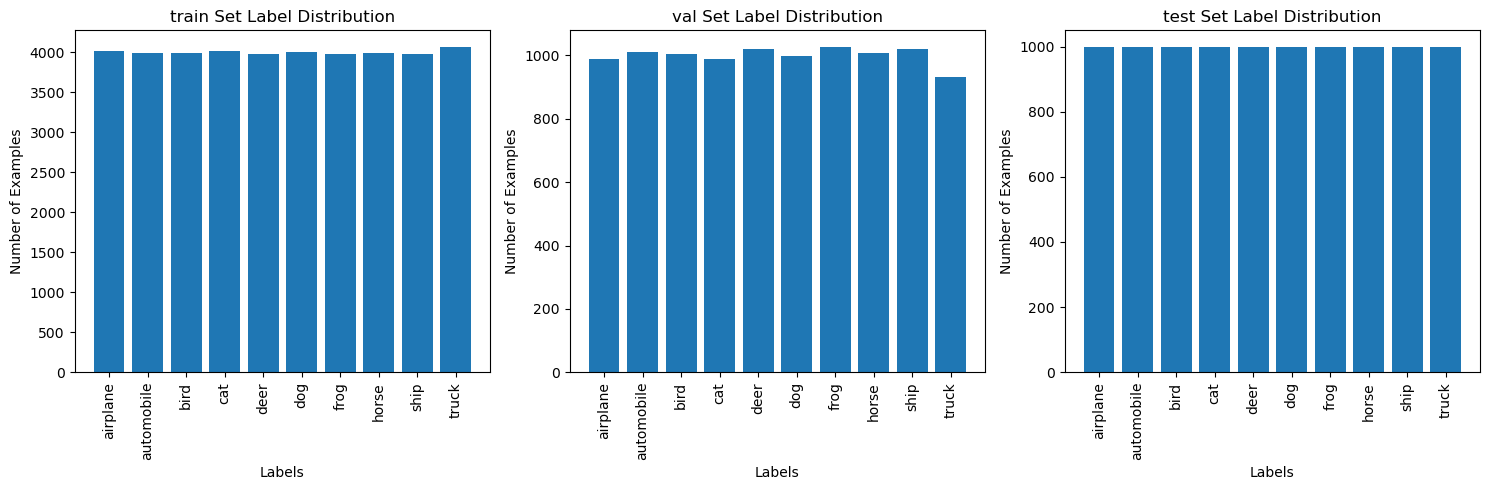

In [9]:
match dataset["name"]:
    case "mnist":
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                transforms.Resize(size=resize_values, antialias=True),
            ]
        )

        ds_train_initial = MNIST(
            root="../dataset/", train=True, download=True, transform=transform
        )
        ds_test = MNIST(
            root="../dataset/", train=False, download=True, transform=transform
        )

        n_examples_test = len(ds_test)
        I = np.random.permutation(len(ds_train_initial))
        ds_val = Subset(ds_train_initial, I[:val_size])
        n_examples_val = len(ds_val)

        ds_train = Subset(ds_train_initial, I[val_size:])
        n_examples_train = len(ds_train)

        print(f"N° samples train: {n_examples_train}")
        print(f"N° samples validation: {n_examples_val}")
        print(f"N° samples test: {n_examples_test}")
        # Imposta la dimensione della figura per contenere i 3 grafici in riga

        plt.figure(figsize=(15, 5))
        plot_hist_labels_distribution(ds_train, dataset["num_classes"], "train", 1)
        plot_hist_labels_distribution(ds_val, dataset["num_classes"], "val", 2)
        plot_hist_labels_distribution(ds_test, dataset["num_classes"], "test", 3)
        plt.tight_layout()  # Ottimizza lo spaziamento tra i grafici

    case "cifar10":
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.49139968, 0.48215841, 0.44653091),
                    (0.24703223, 0.24348513, 0.26158784),
                ),
                transforms.Resize(size=resize_values, antialias=True),
            ]
        )

        ds_train_initial = CIFAR10(
            root="../dataset/", train=True, download=True, transform=transform
        )

        ds_test = CIFAR10(
            root="../dataset/", train=False, download=True, transform=transform
        )

        n_examples_test = len(ds_test)

        print(f"Classes: {ds_train_initial.class_to_idx}")

        I = np.random.permutation(len(ds_train_initial))
        ds_val = Subset(ds_train_initial, I[:val_size])
        n_examples_val = len(ds_val)

        ds_train = Subset(ds_train_initial, I[val_size:])
        n_examples_train = len(ds_train)

        print(f"N° samples train: {n_examples_train}")
        print(f"N° samples validation: {n_examples_val}")
        print(f"N° samples test: {n_examples_test}")
        # Imposta la dimensione della figura per contenere i 3 grafici in riga

        plt.figure(figsize=(15, 5))

        plot_hist_labels_distribution_string(
            ds_train, dataset["num_classes"], "train", 1
        )
        plot_hist_labels_distribution_string(ds_val, dataset["num_classes"], "val", 2)
        plot_hist_labels_distribution_string(ds_test, dataset["num_classes"], "test", 3)

        plt.tight_layout()  # Ottimizza lo spaziamento tra i grafici

plt.savefig("img/dataset_label_distribution.png")
wandb.log(
    {"Dataset Label Distribution": wandb.Image("img/dataset_label_distribution.png")}
)
plt.show()

> ### Dataloaders


In [10]:
# function to view batch image in wandb
def get_image_array(dataloader):
    first_batch = (next(iter(dataloader))[0]).numpy()
    list_batch = np.split(first_batch, len(first_batch))

    if list_batch[0].shape[1] == 1:  # single channels images
        image_array = np.array([el.squeeze() for el in list_batch])
        images = [
            PIL.Image.fromarray((image * 255).astype(np.uint8)) for image in image_array
        ]
    else:  # multiple channels images
        image_array = np.array([el.squeeze().transpose(1, 2, 0) for el in list_batch])
        images = [
            PIL.Image.fromarray((image * 255).astype("uint8"), "RGB")
            for image in image_array
        ]
    return images

In [11]:
# creation of batches
dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size, shuffle=True, num_workers=4
)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False, num_workers=4)

num_batch_train = len(dl_train)
num_batch_val = len(dl_val)
num_batch_test = len(dl_test)

print(f"N° batches train: {num_batch_train}")
print(f"N° batches val: {num_batch_val}")
print(f"N° batches test: {num_batch_test}")

# visualize in wandb a batch of images
wandb.log(
    {
        "examples train": [wandb.Image(image) for image in get_image_array(dl_train)],
        "examples val": [wandb.Image(image) for image in get_image_array(dl_val)],
        "examples test": [wandb.Image(image) for image in get_image_array(dl_test)],
    }
)

N° batches train: 625
N° batches val: 157
N° batches test: 157


> ### Training and evaluation Epoch


In [12]:
# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch, device):
    model.train()

    losses = []

    for xs, ys in tqdm(dl, desc=f"Training epoch {epoch}", leave=True, position=0):
        xs = xs.to(device)
        ys = ys.to(device)

        opt.zero_grad()

        logits = model(xs)
        loss = F.cross_entropy(logits, ys)

        loss.backward()

        opt.step()

        # accumulate values
        losses.append(loss.item())

    return losses


# Function to evaluate a model for a single epoch over the data loader.
def evaluate_model(model, dl, device, split_name=""):
    model.eval()

    predictions = []
    gts = []
    losses = []

    with torch.no_grad():
        for xs, ys in tqdm(
            dl, desc="\tEvaluating on " + split_name, leave=True, position=0
        ):
            xs = xs.to(device)
            ys = ys.to(device)

            logits = model(xs)
            preds = torch.argmax(logits, dim=1)
            loss = F.cross_entropy(logits, ys)

            # accumulate values
            losses.append(loss.item())
            gts.append(ys.detach().cpu().numpy())
            predictions.append(preds.detach().cpu().numpy())

    return gts, predictions, losses

> ## Architectures


> ## MLP

- input_size: dimensione delle feature in ingresso. Nel caso multidimensionale viene eseguito un flatten
- width: numero di neuroni degli strati linear (vincolo: tutti i layer hanno la stessa width)
- depth: numero di hidden layer
- output_size: numero di neuroni nell'ultimo layer linear


In [13]:
class MLP(nn.Module):
    def __init__(self, input_size, width, depth, output_size):
        super().__init__()

        self.input_layer = nn.Linear(input_size, width)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(width, width) for _ in range(depth)]
        )
        self.output_layer = nn.Linear(width, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.input_layer(x)
        out = torch.relu(out)

        # insert ReLU between each Linear layer
        for layer in self.hidden_layers:
            out = layer(out)
            out = torch.relu(out)

        out = self.output_layer(out)
        return out

> ## CNNs


- input_channels: numero di canali dell'esempio in ingresso (nel caso di immagini questo è uguale a 3)
- output_size: numero di neuroni nell'ultimo layer linear
- depth: numero di hidden layer
- channels_intermediate: numero di canali degli strati convoluzionali intermedi alla rete


In [14]:
class CNN(nn.Module):
    def __init__(self, input_channels, output_size, depth, channels_intermediate):
        super().__init__()

        self.output_size = output_size
        self.depth = depth
        self.channels_intermediate = channels_intermediate

        self.kernel_size = (3, 3)
        self.kernel_size_pool = (2, 2)

        self.first_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=self.channels_intermediate,
                kernel_size=self.kernel_size,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=self.kernel_size_pool),
        )

        self.intermediate_block = nn.ModuleList()
        for _ in range(self.depth):
            self.intermediate_block.append(
                nn.Conv2d(
                    in_channels=self.channels_intermediate,
                    out_channels=self.channels_intermediate,
                    kernel_size=self.kernel_size,
                )
            )
            self.intermediate_block.append(nn.ReLU())
            self.intermediate_block.append(
                nn.MaxPool2d(kernel_size=self.kernel_size_pool)
            )

        # Define fully connected layers
        self.fc1 = nn.Linear(self._calculate_flatten_size(input_channels), 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, self.output_size)

    def forward(self, x):
        out = self.first_conv(x)

        for layer in self.intermediate_block:
            out = layer(out)

        out = out.flatten(1)
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out

    def _calculate_flatten_size(self, input_channels):
        # Calculate the size of the tensor after convolutional layers
        fake_input = torch.randn(1, input_channels, resize_values[0], resize_values[1])
        fake_output = self.first_conv(fake_input)

        for layer in self.intermediate_block:
            fake_output = layer(fake_output)

        return fake_output.view(1, -1).size(1)


"""
x = torch.randn(64,3,32,32).to(device)
m = CNN(input_channels= x.shape[1], output_size= 10, depth=2, channels_intermediate=20).to(device)
res = m(x)
print(res.shape)
"""
pass

CNN_GAP è un CNN che dopo aver eseguito una serie di convoluzioni e max pooling effettua un Global avarage pooling (GAP).

Global Average Pooling is a pooling operation designed to replace fully connected layers in classical CNNs. The idea is to generate one feature map for each corresponding category of the classification task in the last mlpconv layer. Instead of adding fully connected layers on top of the feature maps, we take the average of each feature map, and the resulting vector is fed directly into the softmax layer.

One advantage of global average pooling over the fully connected layers is that it is more native to the convolution structure by enforcing correspondences between feature maps and categories. Thus the feature maps can be easily interpreted as categories confidence maps. Another advantage is that there is no parameter to optimize in the global average pooling thus overfitting is avoided at this layer. Furthermore, global average pooling sums out the spatial information, thus it is more robust to spatial translations of the input.


![gap](./img/fcVSgap.png)


In [15]:
class CNN_GAP(nn.Module):
    def __init__(self, input_channels, output_size):
        super(CNN_GAP, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Adaptive AvgPooling to any input size
        self.fc = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def compute_cam(self, x, class_label):
        x = x.to(device)
        self.eval()
        # class_weight: sono i pesi che sono collegati al neurone dell'ultimo layer corrispondente alla classe scelta
        # class_weight.shape ex. torch.Size([10, 128])
        class_weight = (list(self.parameters())[-2]).data
        # channels: numero di canali dell'ultimo layer convoluzionale (canali della feature map)
        channels = class_weight.shape[1]
        layers = list(self.modules())
        index_avg_poll = 0
        for i, layer in enumerate(layers):
            if isinstance(layer, nn.AvgPool2d) or isinstance(
                layer, nn.AdaptiveAvgPool2d
            ):
                index_avg_poll = i
        with torch.no_grad():
            detectors = list(self.modules())[1 : -(len(layers) - index_avg_poll)]
            # act_map.shape ex. torch.Size([64, 128, 4, 4]) (N.B. non è compreso l'avg pooling)
            act_map = reduce(lambda x, f: f(x), detectors, x)
        # weights: pesi relativi al neurone class_label (ex. torch.Size([128]) )
        weights = class_weight[class_label]
        weights = weights.view(-1, channels, 1, 1)  # (1, 128, 1, 1)
        cam = act_map * weights  # (64, 128, 4, 4) * (1, 128, 1, 1) = (64, 128, 4, 4)
        # cam = F.relu(cam.sum(dim=1, keepdim=True))  # (64, 1, 4, 4) #TODO insert relu or no?
        cam = cam.sum(dim=1, keepdim=True)  # (64, 1, 4, 4)
        return cam

La figura mostra i modelli che sono descritti nel paper "Deep Residual Learning for Image Recognition". Nei prossimi blocchi di codice ho implementato "from scratch" tali architetture. I dataset definiti in precedenza sono composti da immagini le cui dimensioni sono piuttosto piccole per architetture troppo profonde. Ho infatti deciso di effettuare un "Resize" di queste immagini ad un dimensione più alta (circa 3 volte in più) per risolvere tale problema

![nets](./img/nets.png)


Si può notare che la prima rete VGG termina con un maxpooling e 3 strati dense mentre le altre due architetture hanno un Gloabal Avarage Pooling e un solo strato dense. La prima architettura non permette quindi di calcolare la Class Activation Map (CAM) per costruzione. Le altre due invece hanno una struttura idonea all'applicazione della CAM proprio come descrive il paper ufficiale.


> ## VGG


In [16]:
VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        "M",
        512,
        512,
        "M",
        512,
        512,
        "M",
    ],
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "VGG19": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}

E' possibile instanziale le tipiche architetture VGG (mediante l'argomento di input architecture): VGG11, VGG13, VGG16 e VGG19.
Nella variabile VGG_types è possibile vedere l'alternarsi di valori interi e stringhe. I valori interi indicano i canali degli strati convoluzionali della rete (in ordine con cui vengono applicati all'input). Le stringhe (presente solo "M") indicano la presenza di un MaxPool2D.


In [17]:
class VGG(nn.Module):
    def __init__(
        self,
        architecture,
        in_channels=3,
        in_height=224,
        in_width=224,
        num_hidden=4096,
        num_classes=10,
    ):
        super(VGG, self).__init__()
        self.in_channels = in_channels
        self.in_width = in_width
        self.in_height = in_height
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.convs = self.init_convs(architecture)
        self.fcs = self.init_fcs(architecture)

    def forward(self, x):
        x = self.convs(x)
        x = x.reshape(x.size(0), -1)
        x = self.fcs(x)
        return x

    def init_convs(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers.extend(
                    [
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding=(1, 1),
                        ),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(),
                    ]
                )
                in_channels = x
            else:
                layers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
        return nn.Sequential(*layers)

    def init_fcs(self, architecture):
        pool_count = architecture.count("M")

        factor = 2**pool_count

        if (self.in_height % factor) + (self.in_width % factor) != 0:
            raise ValueError(
                f"`in_height` and `in_width` must be multiples of {factor}"
            )
        out_height = self.in_height // factor
        out_width = self.in_width // factor

        last_out_channels = next(x for x in architecture[::-1] if type(x) == int)
        return nn.Sequential(
            nn.Linear(last_out_channels * out_height * out_width, self.num_hidden),
            nn.ReLU(),
            nn.Linear(self.num_hidden, self.num_hidden),
            nn.ReLU(),
            nn.Linear(self.num_hidden, self.num_classes),
        )


"""
x = torch.randn(64, 3, 32, 32).to(device)
m = VGG(
    in_channels=3,
    in_height=32,
    in_width=32,
    num_hidden=512,
    architecture=VGG_types["VGG11"],
).to(device)
res = m(x)
"""
pass

> ## PlainNetwork


In [18]:
def get_individual_modules(model):
    individual_modules = []

    def collect_modules(module):
        for layer in module.children():
            if isinstance(layer, nn.Sequential) or isinstance(layer, SequentialBlock):
                # Se il layer è un modulo Sequential, richiama ricorsivamente la funzione
                collect_modules(layer)
            else:
                # Aggiungi il modulo singolo alla lista
                individual_modules.append(layer)

    collect_modules(model)

    return individual_modules


# CNN no residuals
class SequentialBlock(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, stride=1):
        super(SequentialBlock, self).__init__()
        self.num_layers = num_layers

        self.stack = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=stride, padding=1
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.stack(x)


class PlainNetwork(nn.Module):
    def __init__(
        self, num_layers, block, image_channels, num_classes=dataset["num_classes"]
    ):
        super(PlainNetwork, self).__init__()

        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]

        self.in_channels = 64

        self.first_layers = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.layer1 = self.make_layers(
            num_layers, block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self.make_layers(
            num_layers, block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self.make_layers(
            num_layers, block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self.make_layers(
            num_layers, block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.first_layers(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(
        self, num_layers, block, num_residual_blocks, intermediate_channels, stride
    ):
        layers = []
        layers.append(
            block(num_layers, self.in_channels, intermediate_channels, stride)
        )
        self.in_channels = intermediate_channels
        for _ in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels))
        return nn.Sequential(*layers)

    def compute_cam(self, x, class_label):
        x = x.to(device)
        self.eval()
        # class_weight.shape --> torch.Size([10, 128])
        # sono i pesi che sono collegati al neurone dell'ultimo layer corrispondente alla classe scelta
        class_weight = (list(self.parameters())[-2]).data
        channels = class_weight.shape[1]
        # numero di canali dell'ultimo layer convoluzionale (canali della feature map)
        layers = get_individual_modules(self)
        index_avg_poll = 0
        for i, layer in enumerate(layers):
            if isinstance(layer, nn.AdaptiveAvgPool2d):
                index_avg_poll = i

        with torch.no_grad():
            detectors = layers[0 : -(len(layers) - index_avg_poll)]
            # act_map.shape --> torch.Size([64, 128, 4, 4])
            act_map = reduce(lambda x, f: f(x), detectors, x)
        # torch.Size([128]) ricavo i pesi relativi al neurone class_label
        weights = class_weight[class_label]
        weights = weights.view(-1, channels, 1, 1)  # (1, 128, 1, 1)
        cam = act_map * weights  # (64, 128, 4, 4) * (1, 128, 1, 1) = (64, 128, 4, 4)
        # cam = F.relu(cam.sum(dim=1, keepdim=True))  # (64, 1, 4, 4)
        cam = cam.sum(dim=1, keepdim=True)  # (64, 1, 4, 4)
        return cam


def CNN18Plain(img_channels=batch_shape[1]):
    return PlainNetwork(18, SequentialBlock, img_channels)


def CNN34Plain(img_channels=batch_shape[1]):
    return PlainNetwork(34, SequentialBlock, img_channels)


def CNN50Plain(img_channels=batch_shape[1]):
    return PlainNetwork(50, SequentialBlock, img_channels)


"""
x = torch.randn(64, 3, 32, 32).to(device)
model = CNN34Plain(3, 10).to(device)
res = model(x)
print(res.shape)
"""
"""
class_target = 3
x, y = next(iter(dl_train))
model = CNN34Plain(batch_shape[1], dataset["num_classes"]).to(device)
model.load_state_dict(torch.load(path_models))
print(*get_individual_modules(model), sep="\n")
cam = model.compute_cam(x, class_target)
"""

pass

> ## ResNet


In [19]:
class BlockResidual(nn.Module):
    def __init__(
        self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1
    ):
        super(BlockResidual, self).__init__()
        self.num_layers = num_layers

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=1, stride=1, padding=0
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(
        self, num_layers, block, image_channels, num_classes=dataset["num_classes"]
    ):
        super(ResNet, self).__init__()

        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]

        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(
            num_layers, block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self.make_layers(
            num_layers, block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self.make_layers(
            num_layers, block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self.make_layers(
            num_layers, block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(
        self, num_layers, block, num_residual_blocks, intermediate_channels, stride
    ):
        layers = []
        identity_downsample = nn.Sequential(
            nn.Conv2d(
                self.in_channels, intermediate_channels, kernel_size=1, stride=stride
            ),
            nn.BatchNorm2d(intermediate_channels),
        )

        layers.append(
            block(
                num_layers,
                self.in_channels,
                intermediate_channels,
                identity_downsample,
                stride,
            )
        )
        self.in_channels = intermediate_channels
        for _ in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels))
        return nn.Sequential(*layers)

    def compute_cam(self, x, class_label):
        x = x.to(device)
        self.eval()
        class_weight = (list(self.parameters())[-2]).data

        # class_weight.shape --> torch.Size([10, 128]) # sono i pesi che sono collegati al neurone dell'ultimo layer corrispondente alla classe scelta
        channels = class_weight.shape[1]
        # numero di canali dell'ultimo layer convoluzionale (canali della feature map)

        layers = get_individual_modules(self)

        index_avg_poll = 0
        for i, layer in enumerate(layers):
            if isinstance(layer, nn.AdaptiveAvgPool2d):
                index_avg_poll = i

        with torch.no_grad():
            detectors = layers[0 : -(len(layers) - index_avg_poll)]
            print(*detectors, sep="\n")

            act_map = reduce(
                lambda x, f: f(x), detectors, x
            )  # act_map.shape --> torch.Size([64, 128, 4, 4])

        weights = class_weight[
            class_label
        ]  # torch.Size([128]) ricavo i pesi relativi al neurone class_label
        weights = weights.view(-1, channels, 1, 1)  # (1, 128, 1, 1)
        cam = act_map * weights  # (64, 128, 4, 4) * (1, 128, 1, 1) = (64, 128, 4, 4)
        cam = cam.sum(dim=1, keepdim=True)  # (64, 1, 4, 4)

        # cam = F.relu(cam.sum(dim=1, keepdim=True))  # (64, 1, 4, 4)
        return cam


def ResNet18(img_channels=batch_shape[1]):
    return ResNet(18, BlockResidual, img_channels)


def ResNet34(img_channels=batch_shape[1]):
    return ResNet(34, BlockResidual, img_channels)


def ResNet50(img_channels=batch_shape[1]):
    return ResNet(50, BlockResidual, img_channels)


"""
x = torch.randn(64, 3, 32, 32).to(device)
model = ResNet34(3, 10).to(device)
res = model(x)
print(res.shape)
"""
pass

> ## Creazione del modello


La cella sottostante ha il compito di creare il modello selezionato tra gli iperparametri. Si può notare che la creazione coinvolge una struttura "switch-case" dove in ogni case sono presenti gli iperparametri della specifica architettura. Tali iperparametri vengono aggiunti anche su wandb al fine di sperimentare diversi valori degli stessi.


In [20]:
match architecture["name"]:
    case "MLP":
        width = 64
        depth = 8

        wandb.config.update({"width": width})
        wandb.config.update({"depth": depth})

        model = MLP(
            input_size, width=width, depth=depth, output_size=dataset["num_classes"]
        )
    case "CNN":
        depth = 2
        channels_intermediate = 32

        wandb.config.update({"depth": depth})
        wandb.config.update({"channels_intermediate": channels_intermediate})

        model = CNN(
            input_channels=batch_shape[1],
            output_size=dataset["num_classes"],
            depth=depth,
            channels_intermediate=channels_intermediate,
        )
    case "CNN_GAP":
        model = CNN_GAP(
            input_channels=batch_shape[1], output_size=dataset["num_classes"]
        )
    case "VGG":
        # type_vgg available: "VGG11", "VGG13", "VGG16", "VGG19"
        type_vgg = "VGG19"
        wandb.config.update({"type_vgg": type_vgg})

        model = VGG(
            in_channels=batch_shape[1],
            in_height=batch_shape[2],
            in_width=batch_shape[3],
            architecture=VGG_types[type_vgg],
        )
    case "PlainNetwork":
        # depth available: "18", "34", "50"
        depth = "50"
        wandb.config.update({"depth": depth})

        match depth:
            case "18":
                model = CNN18Plain(batch_shape[1])
            case "34":
                model = CNN34Plain(batch_shape[1])
            case "50":
                model = CNN50Plain(batch_shape[1])
    case "ResNet":
        # depth available: "18", "34", "50"
        depth = "50"
        wandb.config.update({"depth": depth})

        match depth:
            case "18":
                model = ResNet18(batch_shape[1])
            case "34":
                model = ResNet34(batch_shape[1])
            case "50":
                model = ResNet50(batch_shape[1])

model = model.to(device)

print(f'Architecture name: {architecture["name"]}')
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print(f"N° of parameters: {params}")
wandb.config.update({"params": params})

print(f"Model is in {next(model.parameters()).device}")
print("\n\nLayers of the network sorted:\n")
print(*get_individual_modules(model), sep="\n")

Architecture name: ResNet
N° of parameters: 11242826
Model is in cuda:0


Layers of the network sorted:

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
BlockResidual(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (identity_downsample): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
BlockResidual(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, m

> ## Optimizer


In questa sezione è possibile variare l'ottimizzatore e i suoi iperparametri. Il learning rate iniziale è fisso ma questo varia durante l'addestramento attraverso uno strumento chiamato scheduler.

In generale il lr può essere variato in base al numero di epoche oppure alle performance su un validation set. In genere il lr si vuole decrementare e non incrementare ma dipende molto dal problema che stiamo affrontando.

In questo lavoro è stato scelto uno scheduler che monitora il valore della validation accuracy e se questa rimane invariata per più di 5 epochee viene decrementato il lr. Nelle reti più profonde questo strumento è fondamentale dato che scegliere il lr di partenza è sempre una scelta critica.


In [ ]:
match optimizer["name"]:
    case "adam":
        # betas, eps, weight_decay
        opt = torch.optim.Adam(params=model.parameters(), lr=lr)
    case "sgd":
        # momentum, weight_decay
        opt = torch.optim.SGD(params=model.parameters(), lr=lr)

sched = lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode="min", patience=5)
print(f'Optimizer: {optimizer["name"]} \n\n{opt.state_dict}')

## Visualization of pytorch models in the form of visual graphs


In [ ]:
model_copy = copy.deepcopy(model)
model_graph = draw_graph(model_copy, input_size=batch_shape, device="meta")
image = model_graph.visual_graph
image.save("img/visual_graph")
wandb.log({"Model Visual Graph": wandb.Image(image.render(format="png", cleanup=True))})
# image

## Computational Graph


In [ ]:
input_tensor = torch.randn(batch_shape).to(device)

PIL.Image.MAX_IMAGE_PIXELS = 123626472

out = model(input_tensor)
graph = make_dot(
    out, params=dict(model.named_parameters()), show_attrs=True, show_saved=True
)
graph.save("img/computational_graph")
wandb.log(
    {"Computational Graph": wandb.Image(graph.render(format="png", cleanup=True))}
)
# graph # decommentare per vedere il grafo computazionale (enorme per reti molto profonde)

> ## Training Loop


In [ ]:
def plot_gradients_magnitudes(model, epoch):
    # loss.backward REQUIRED
    gradient_magnitudes = []
    names_layers = []
    for name, param in model.named_parameters():
        if param.grad is not None and "bias" not in name:
            gradient_magnitudes.append(param.grad.norm().item())
            names_layers.append(name)

    # Plot dei gradienti
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(gradient_magnitudes)), gradient_magnitudes)
    plt.xlabel("Parameters Layers")
    plt.ylabel("Gradient Magnitude")
    plt.title("Epoch: " + str(epoch) + " - Gradient Magnitudes of Model Parameters")

    dir_path = "gradient_magnitudes/" + architecture["name"]
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    plt_path = dir_path + "/gradient_magnitudes_epoch_" + str(epoch) + ".png"

    if os.path.exists(plt_path):
        # Se il file esiste, svuota la cartella
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                os.remove(file_path)
    plt.savefig(plt_path)
    plt.close()
    data = [
        [name, magnitude] for name, magnitude in zip(names_layers, gradient_magnitudes)
    ]
    table = wandb.Table(data=data, columns=["Parameter", "Gradient Magnitude"])

    wandb.log(
        {
            f"Gradient Magnitudes Epoch {epoch}": wandb.plot.bar(
                table,
                "Parameter",
                "Gradient Magnitude",
                title="Gradient Magnitudes of Model Parameters - Epoch " + str(epoch),
            )
        }
    )

    # log_data = {f"Gradient_Magnitudes_Epoch_{epoch}": data}
    # wandb.log(log_data)

La cella successiva ha il compito di fare l'addestramento, valutare il modello su un validation set e salvare il modello risultante in una cartella chiamata "model". Durante il training per ogni epoca viene calcolata la magnitudine dei gradienti per ogni layer con parametri e sarà visualizzabile successivamente in una cella successiva.


In [ ]:
os.makedirs("./models/" + architecture["name"], exist_ok=True)

path_models = (
    "./models/"
    + architecture["name"]
    + "/model_"
    + dataset["name"]
    + "_"
    + architecture["name"]
    + datetime.now().strftime("%Y%m%d_%H%M%S")
    + ".pth"
)

wandb.config.update({"path_models": path_models})

if not os.path.exists(path_models):  # se non esiste fai l'addestramento
    for epoch in range(epochs):
        losses_train = train_epoch(model, dl_train, opt, epoch, device=device)

        plot_gradients_magnitudes(model, epoch)

        gts, predictions, losses_val = evaluate_model(
            model, dl_val, device=device, split_name="val"
        )

        loss_val = np.mean(losses_val)
        sched.step(loss_val)
        val_acc = accuracy_score(np.hstack(gts), np.hstack(predictions))
        wandb.log(
            {
                "accuracy validation": val_acc,
                "loss training": np.mean(losses_train),
                "loss validation:": loss_val,
            }
        )
    torch.save(model.state_dict(), path_models)
else:
    print(f"Model exist on path {path_models}")

In [ ]:
path = "./gradient_magnitudes/" + architecture["name"]

immagini = os.listdir(path)

num_colonne = 3  # Imposta il numero di colonne desiderato
num_immagini = len(immagini)
num_righe = -(-num_immagini // num_colonne)  # Calcola il numero di righe necessario

fig, axes = plt.subplots(
    num_righe, num_colonne, figsize=(num_colonne * 5, num_righe * 5)
)

for i, img in enumerate(immagini):
    riga = i // num_colonne
    colonna = i % num_colonne
    image_path = os.path.join(path, img)
    img = Image.open(image_path)
    axes[riga, colonna].imshow(img)
    axes[riga, colonna].axis("off")  # Nasconde i valori degli assi

# Nasconde gli assi per gli eventuali assi non utilizzati
for r in range(num_righe):
    for c in range(num_colonne):
        if r * num_colonne + c >= num_immagini:
            axes[r, c].axis("off")

plt.tight_layout()  # Impedisce sovrapposizioni di layout
plt.savefig("img/gradient_magnitude.png")

for i, (name, param) in enumerate(model.named_parameters()):
    if param.grad is not None and "bias" not in name:
        print(f"{i} --> {name}")

plt.show()

> ## Evaluation


Evaluation sul test set (stessa funzione utilizzata per il validation set).


In [ ]:
model.load_state_dict(torch.load(path_models, map_location=device))
gts, predictions, losses_val = evaluate_model(
    model, dl_test, device=device, split_name="test"
)

In questa parte viene visualizzato il classification report e calcolata l'accuracy media (alla fine dell'addestramento).


In [ ]:
loss_val = np.mean(losses_val)
val_acc = accuracy_score(np.hstack(gts), np.hstack(predictions))
report_acc = classification_report(
    np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3
)
print(f"Accuracy report on TEST:\n {report_acc}")
print(f"\nAccuracy at {epochs} epoch on TEST:\n {val_acc}")

In [ ]:
# visualizza il classification report su wandb
df = pd.DataFrame.from_dict(
    classification_report(
        np.hstack(gts),
        np.hstack(predictions),
        zero_division=0,
        digits=3,
        output_dict=True,
    )
).transpose()
df_label = df[:10]
df_label.insert(0, "class_label", ds_test.classes)
df_label.loc[:, "support"] = df_label["support"].astype(int)

wandb.log({"Classification report": wandb.Table(dataframe=df_label)})

creazione della matrice di confuzione e visualizzazione su wandb


In [ ]:
all_gts = [item for sublist in gts for item in sublist]
all_predictions = [item for sublist in predictions for item in sublist]

print(
    f"Confusione Matrix Test Set\n{confusion_matrix(all_gts, all_predictions, labels=torch.arange(0,10))}"
)

wandb.log(
    {
        "conf_mat": wandb.plot.confusion_matrix(
            probs=None,
            y_true=all_gts,
            preds=all_predictions,
            class_names=ds_train_initial.classes,
            title="Confusion Matrix Test Set",
        )
    },
)

> ## Class Activation Mapping


Questa funzione prende un batch di immagini e una class label e stampa le immagini e la classi activation mapping di solo le immagini con etichetta class label.
Questa operazione viene ripetuta per ogni class label.
Per calcolare la CAM occorre:

- la classe target
- i pesi dell'ultimo layer collegati alla classe target
- la feature map in uscita dall'ultimo layer convoluzionale (in particolare il numero dei canali della feature map)

![cams](./img/cam.png)


In [ ]:
def plot_cam_with_images(model, x, class_target, n_img, height=32, width=32):
    class_label = {v: k for k, v in ds_train_initial.class_to_idx.items()}
    resize = transforms.Resize(size=(height, width), antialias=None)
    img = resize(x)
    # print(cam.shape) # (n°images, 1,4,4)
    cam = model.compute_cam(x, class_target)
    class_target = [class_target] * len(x)
    probs = F.softmax(model(x), dim=1)

    fig, ax = plt.subplots(2, n_img, figsize=(24, 8), squeeze=False)

    save_dir = f"./cam_images/{dataset['name']}/"
    os.makedirs(save_dir, exist_ok=True)

    for b in range(n_img):
        heatmap = cam[b].detach().cpu()
        heatmap = resize(heatmap).permute(1, 2, 0)
        heatmap = torch.clamp(heatmap, min=0)  # Imposta a 0 i valori negativi
        heatmap = heatmap / heatmap.max()
        # Normalizza tra 0 e 1 dividendo per il massimo valore
        # Plot original image
        img_display = (img[b].permute(1, 2, 0).cpu() + 1) / 2
        # Normalize image to [0, 1]
        img_display = torch.clamp(img_display, min=0, max=1)
        ax[0, b].imshow(img_display)
        # Plot CAM over the original image
        img_display_heatmap = img_display * 0.5 + heatmap * 0.5
        # Blend heatmap with image
        ax[1, b].imshow(img_display_heatmap)
        ax[1, b].imshow(heatmap, alpha=0.5, cmap="jet")  # Plot normalized heatmap
        ax[1, b].set_xlabel(
            f"Pr({class_label[class_target[b]]})={probs[b][class_target[b]].item()*100:.2f}%",
            color="black",
        )
    img_name = f"{class_target[0]}_image.png"
    img_path = os.path.join(save_dir, img_name)
    plt.savefig(img_path)
    wandb.log({f"Sample {dataset['name']}_{class_target[0]}": wandb.Image(img_path)})
    fig.tight_layout()

In [ ]:
os.makedirs("./cam_images/", exist_ok=True)

"""
assert (
    architecture["name"] == "CNN_GAP"
    or architecture["name"] == "PlainNetwork"
    or architecture["name"] == "ResNet"
), "L'architettura non corrisponde a CNN_GAP, PlainNetwork o ResNet."
"""

if (
    architecture["name"] == "CNN_GAP"
    or architecture["name"] == "PlainNetwork"
    or architecture["name"] == "ResNet"
):
    model.load_state_dict(torch.load(path_models))
    print(f'Model: {architecture["name"]}\n')
    x, y = next(iter(dl_test))  # retrieve first batch of my dataloader
    label_targets = torch.arange(0, dataset["num_classes"], 1).tolist()  # labels
    class_label = {v: k for k, v in ds_train_initial.class_to_idx.items()}
    for label_target in label_targets:
        imgs_by_label = []
        for img, label in zip(x, y):
            if label.item() == label_target:
                imgs_by_label.append(img)
        print(f"Img with target {class_label[label_target]}: {len(imgs_by_label)}")

        imgs_by_label = torch.stack(imgs_by_label).to(device)

        plot_cam_with_images(
            model, imgs_by_label, class_target=label_target, n_img=len(imgs_by_label)
        )

else:
    print("L'architettura non corrisponde a CNN_GAP, PlainNetwork o ResNet.")

Le architetture devono avere necessariamente un avarage pooling dopo gli strati convoluzionali per poter applicare la CAM.
In pytorch puoi usare avarage pooling 2d specificando le dimensioni del kernel altrimenti puoi usare Adaptive avarage pooling specificando che in uscita vuoi qualcosa di dimensioni 1x1.


In [ ]:
wandb.finish()

### - Per ogni run:

- distribuzione delle label
- modello sotto forma di visual graph
- plot magnitudine dei gradiente per ogni epoca
- curva di training loss e validation loss in funzione delle epoche
- curva della validation accuracy in funzione delle epoche

- evaluation:

  - classification report
  - matrice di confusione

- explain the predictions

  - visualizzazione di un batch delle heatmap divise per label


## Lista esperimenti


## MNIST

- mnist, resized_values = 28,28, MLP --> 2,4,6,8
- mnist, resized_values = 28,28, CNN --> 1,2
- mnist, resized_values = 28,28, CNN_GAP
- mnist, resized_values = 96,96, VGG11
- mnist, resized_values = 96,96, VGG13
- mnist, resized_values = 96,96, VGG16
- mnist, resized_values = 96,96, PlainNetwork18

---

## CIFAR10

- cifar10, resized_values = 32, 32, MLP --> 2,4,6,8
- cifar10, resized_values = 32, 32, CNN --> 1,2
- cifar10, resized_values = 32, 32, CNN_GAP
- cifar10, resized_values = 96,96, VGG11
- cifar10, resized_values = 96,96, VGG16
- cifar10, resized_values = 96,96, VGG19
- cifar10, resized_values = 96,96, PlainNetwork18
- cifar10, resized_values = 96,96, PlainNetwork34
- cifar10, resized_values = 96,96, PlainNetwork50
- cifar10, resized_values = 96,96, ResNet18
- cifar10, resized_values = 96,96, ResNet34
- cifar10, resized_values = 96,96, ResNet50

---


<span style="color: red;">

## Link esperimenti svolti: [Link wandb](https://wandb.ai/team-vittoriocasula/Lab1_DLA/reports/Esperimenti-Lab-1-DLA--Vmlldzo2Mjk1NDE3?accessToken=b45328mwbbpm714g3hkcefwgcjsd6tthd9klf0clfh3p5rr0csqs00zzu5y6xkg8)

</span>
